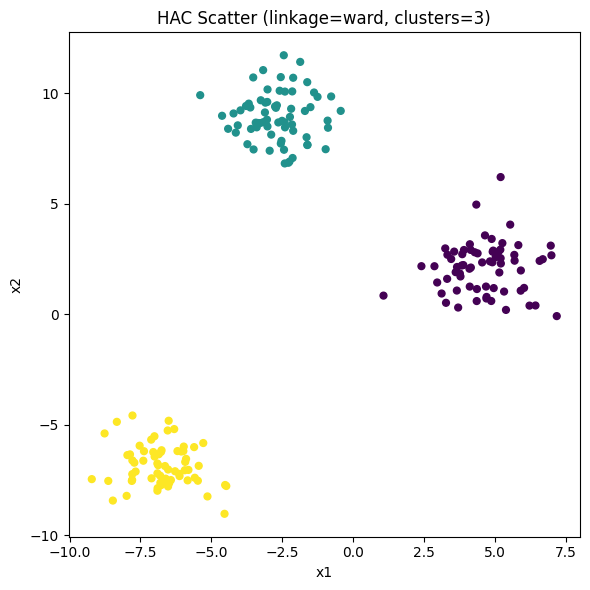

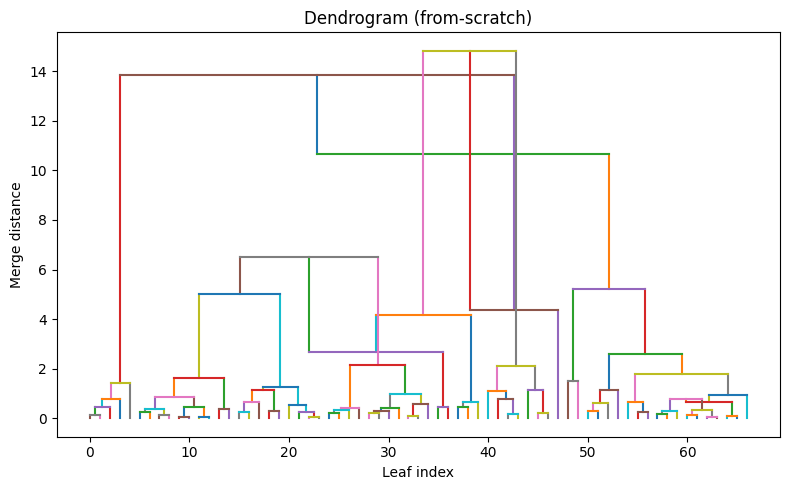

[라벨 기반 군집 구성] 총 3개 군집

■ Cluster 0  | size=67
  indices: [0, 8, 10, 11, 12, 13, 14, 18, 20, 21, 29, 30, 31, 40, 43, 45, 46, 48, 57, 59, 73, 75, 76, 78, 81] ... [191, 198, 199] (총 67개)

■ Cluster 1  | size=67
  indices: [1, 6, 16, 23, 25, 26, 28, 34, 35, 37, 39, 41, 49, 51, 53, 54, 55, 58, 61, 66, 67, 69, 70, 72, 74] ... [194, 196, 197] (총 67개)

■ Cluster 2  | size=66
  indices: [2, 3, 4, 5, 7, 9, 15, 17, 19, 22, 24, 27, 32, 33, 36, 38, 42, 44, 47, 50, 52, 56, 60, 62, 63] ... [192, 193, 195] (총 66개)


In [2]:

import numpy as np
import matplotlib.pyplot as plt

# ---- (옵션) 데이터 생성: make_blobs / make_moons 중 선택 가능 ----
# 요구사항상 "군집화 라이브러리 미사용"이므로, 클러스터링은 직접구현.
# 데이터 생성은 편의를 위해 sklearn 사용 (원치 않으면 X를 직접 주입하세요).
try:
    from sklearn.datasets import make_blobs, make_moons
    HAVE_SK = True
except:
    HAVE_SK = False

# -----------------------------
# 하이퍼파라미터
# -----------------------------
DATASET = 'blobs'  # 'blobs' or 'moons' (moons를 원하면 HAVE_SK가 True여야 함)
N_SAMPLES = 200
RANDOM_STATE = 42
LINKAGE = 'ward'   # 'single' | 'complete' | 'average' | 'ward'
TARGET_K = 3       # 최종 군집 수 (또는 아래 CUT_DIST 사용)
CUT_DIST = None    # 병합거리 기준 컷(예: 5.0). None이면 K 기준 사용.

np.random.seed(RANDOM_STATE)

# -----------------------------
# 1) 데이터 준비
# -----------------------------
if HAVE_SK and DATASET == 'moons':
    X, _ = make_moons(n_samples=N_SAMPLES, noise=0.12, random_state=RANDOM_STATE)
elif HAVE_SK and DATASET == 'blobs':
    X, _ = make_blobs(n_samples=N_SAMPLES, centers=3, cluster_std=1.1, random_state=RANDOM_STATE)
else:
    # sklearn이 없거나 직접 생성 원할 때: 임의 2D 가우시안 3개
    c1 = np.random.randn(N_SAMPLES//3, 2) + np.array([0,0])
    c2 = np.random.randn(N_SAMPLES//3, 2) + np.array([5,5])
    c3 = np.random.randn(N_SAMPLES - 2*(N_SAMPLES//3), 2) + np.array([-5,4])
    X = np.vstack([c1, c2, c3])

N, D = X.shape

# -----------------------------
# 2) 유틸: 거리계산 / 초기화
# -----------------------------
def pairwise_distance(a, b, metric='euclidean'):
    """
    a: (Na, d), b: (Nb, d) -> (Na, Nb)
    """
    if metric == 'euclidean':
        a2 = np.sum(a*a, axis=1, keepdims=True)      # (Na,1)
        b2 = np.sum(b*b, axis=1, keepdims=True).T    # (1,Nb)
        d2 = a2 + b2 - 2 * a @ b.T
        d2 = np.maximum(d2, 0.0)
        return np.sqrt(d2)
    elif metric == 'manhattan':
        return np.sum(np.abs(a[:,None,:] - b[None,:,:]), axis=2)
    else:
        raise ValueError("metric must be 'euclidean' or 'manhattan'")

def init_clusters(N):
    # 각 점이 하나의 군집
    clusters = [set([i]) for i in range(N)]
    sizes = [1]*N
    ids = list(range(N))  # 덴드로그램 기록용 실제 ID (new cluster는 N부터 증가)
    return clusters, sizes, ids

def init_dist_matrix(X, metric='euclidean'):
    D = pairwise_distance(X, X, metric=metric)
    np.fill_diagonal(D, np.inf)  # 자기자신은 병합 금지
    return D

# -----------------------------
# 3) Lance–Williams 갱신
# -----------------------------
def lw_coeffs(linkage, sizeA, sizeB, sizeC):
    if linkage == 'single':
        # αA=αB=1/2, β=0, γ=-1/2
        return 0.5, 0.5, 0.0, -0.5
    elif linkage == 'complete':
        # αA=αB=1/2, β=0, γ=+1/2
        return 0.5, 0.5, 0.0, +0.5
    elif linkage == 'average':
        # αA=|A|/(|A|+|B|), αB=|B|/(|A|+|B|), β=0, γ=0
        s = sizeA + sizeB
        return sizeA/s, sizeB/s, 0.0, 0.0
    elif linkage == 'ward':
        # αA=(|A|+|C|)/S, αB=(|B|+|C|)/S, β=-|C|/S, γ=0,  S=|A|+|B|+|C|
        S = sizeA + sizeB + sizeC
        return (sizeA+sizeC)/S, (sizeB+sizeC)/S, -sizeC/S, 0.0
    else:
        raise ValueError("linkage must be 'single'|'complete'|'average'|'ward'")

def update_distances(D, clusters, sizes, i, j, linkage):
    """
    군집 i와 j를 병합해서 i 위치에 두고, j를 제거.
    D, clusters, sizes는 i/j 기준으로 인덱스가 정렬되어 있다고 가정.
    """
    n_current = len(clusters)
    # 새 군집 i와 다른 군집 c의 거리 갱신
    for c in range(n_current):
        if c == i or c == j:
            continue
        # 기존 거리
        dAC = D[min(i,c), max(i,c)]
        dBC = D[min(j,c), max(j,c)]
        dAB = D[min(i,j), max(i,j)]
        aA, aB, beta, gamma = lw_coeffs(linkage, sizes[i], sizes[j], sizes[c])
        dMC = aA*dAC + aB*dBC + beta*dAB + gamma*abs(dAC - dBC)
        D[min(i,c), max(i,c)] = dMC

    # i와 j의 행/열 정리: i는 유지, j는 삭제
    # 우선 i와 j 사이 거리 무한대로
    D[min(i,j), max(i,j)] = np.inf

    # j행/열 제거
    mask = np.ones(n_current, dtype=bool)
    mask[j] = False
    D = D[np.ix_(mask, mask)]

    return D

# -----------------------------
# 4) HAC 본체 (Z 생성)
# -----------------------------
def hac_fit(X, linkage='ward', metric='euclidean', stop_k=None, stop_dist=None):
    """
    반환: Z (N-1, 4)  -> [idA, idB, dist, sizeMerged]
    """
    N = len(X)
    clusters, sizes, ids = init_clusters(N)
    D = init_dist_matrix(X, metric=metric)
    Z = []
    next_id = N  # 새 군집 id는 N부터

    def find_closest(D):
        # 전체에서 최소값 위치 찾기
        idx = np.argmin(D)
        n = D.shape[0]
        i, j = divmod(idx, n)
        if i == j:
            # 안전장치: 대각=inf이므로 여기 오면 안 됨
            return None, None, np.inf
        if i > j:
            i, j = j, i
        return i, j, D[i, j]

    while True:
        k_now = len(clusters)
        # 종료 조건 확인
        if stop_k is not None and k_now <= stop_k:
            break
        i, j, dij = find_closest(D)
        if stop_dist is not None and dij >= stop_dist:
            break

        # 병합 기록 (실제 id 사용)
        idA, idB = ids[i], ids[j]
        sizeMerged = sizes[i] + sizes[j]
        Z.append([idA, idB, float(dij), int(sizeMerged)])

        # 병합: i <- i ∪ j
        clusters[i] = clusters[i] | clusters[j]
        sizes[i] = sizeMerged
        ids[i] = next_id
        next_id += 1

        # 거리 갱신
        D = update_distances(D, clusters, sizes, i, j, linkage)

        # 자료구조에서 j 제거
        del clusters[j]
        del sizes[j]
        del ids[j]

        # 반복
        if len(clusters) == 1:
            break

    return np.array(Z, dtype=float), ids, clusters

# -----------------------------
# 5) 커팅(라벨 만들기)
# -----------------------------
def fcluster_by_k(Z, k, n_leaves):
    """
    Z: (n-1,4) with [idA,idB,dist,size]
    k개 군집이 되도록 위에서부터 병합 취소 개념으로 라벨 생성
    """
    # 유니온파인드 방식
    parent = {i:i for i in range(n_leaves)}
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    def union(a,b,new_id):
        ra, rb = find(a), find(b)
        parent[ra] = new_id
        parent[rb] = new_id
        parent[new_id] = new_id

    # 초기: 각 leaf는 자기 자신
    current_components = {i for i in range(n_leaves)}
    next_id = n_leaves

    # Z를 낮은 거리→높은 거리 순(이미 그러함)으로 병합
    for idA, idB, dist, size in Z:
        idA, idB = int(idA), int(idB)
        union(idA, idB, next_id)
        current_components.discard(idA)
        current_components.discard(idB)
        current_components.add(next_id)
        next_id += 1
        if len(current_components) <= k:
            break

    # 각 leaf의 루트 id를 기준으로 라벨 압축
    roots = {}
    labels = np.zeros(n_leaves, dtype=int)
    lbl = 0
    for i in range(n_leaves):
        r = find(i)
        if r not in roots:
            roots[r] = lbl
            lbl += 1
        labels[i] = roots[r]
    return labels

def fcluster_by_dist(Z, t, n_leaves):
    """
    거리 임계 t로 자르기: 병합거리 <= t인 것만 반영하고 나머지는 병합하지 않음
    """
    parent = {i:i for i in range(n_leaves)}
    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x
    def union(a,b,new_id):
        ra, rb = find(a), find(b)
        parent[ra] = new_id
        parent[rb] = new_id
        parent[new_id] = new_id

    current_components = {i for i in range(n_leaves)}
    next_id = n_leaves

    for idA, idB, dist, size in Z:
        if dist > t:
            break
        idA, idB = int(idA), int(idB)
        union(idA, idB, next_id)
        current_components.discard(idA)
        current_components.discard(idB)
        current_components.add(next_id)
        next_id += 1

    roots = {}
    labels = np.zeros(n_leaves, dtype=int)
    lbl = 0
    for i in range(n_leaves):
        r = find(i)
        if r not in roots:
            roots[r] = lbl
            lbl += 1
        labels[i] = roots[r]
    return labels

# -----------------------------
# 6) 덴드로그램 그리기(간단 구현)
# -----------------------------
def build_tree(Z, n_leaves):
    """
    Z: (n-1,4) -> dict 형태 트리 구성
    node_id < n_leaves : leaf (dist=0)
    node_id >= n_leaves: internal
    """
    nodes = {i: {'id': i, 'children': [], 'dist': 0.0} for i in range(n_leaves)}
    for idA, idB, dist, size in Z:
        idA, idB = int(idA), int(idB)
        node_id = len(nodes)
        nodes[node_id] = {'id': node_id, 'children':[idA, idB], 'dist': float(dist)}
    return nodes

def dendro_layout(nodes, n_leaves):
    """
    간단 레이아웃: 좌->우 leaf 순서대로 x=0..(n_leaves-1), y=merge distance
    """
    # 자식→부모 매핑 만들기
    parent = {}
    max_id = max(nodes.keys())
    for nid, nd in nodes.items():
        for ch in nd['children']:
            parent[ch] = nid
    # root 찾기
    root = None
    for nid in range(max_id, -1, -1):
        if nid in nodes and nid not in parent:
            root = nid
            break

    # leaf 순서 (왼->오) : 재귀 DFS
    order = []
    def dfs(nid):
        if len(nodes[nid]['children']) == 0:
            order.append(nid)
            return
        a,b = nodes[nid]['children']
        dfs(a); dfs(b)
    dfs(root)
    # leaf x 위치
    x_pos = {}
    for i,nid in enumerate(order):
        x_pos[nid] = i

    # 내부 노드 x는 자식 x의 평균
    def assign_x(nid):
        if nid in x_pos:
            return x_pos[nid]
        a,b = nodes[nid]['children']
        xa = assign_x(a); xb = assign_x(b)
        x_pos[nid] = 0.5*(xa+xb)
        return x_pos[nid]
    assign_x(root)

    return root, x_pos

def plot_dendrogram(Z, n_leaves):
    nodes = build_tree(Z, n_leaves)
    root, x_pos = dendro_layout(nodes, n_leaves)

    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    # 재귀적으로 선 그리기
    def draw(nid):
        nd = nodes[nid]
        if len(nd['children']) == 0:
            # leaf: 세로선 없음, x tick으로 표시
            ax.plot([x_pos[nid], x_pos[nid]], [0, 0])
            return
        a,b = nd['children']
        da, db = nodes[a]['dist'], nodes[b]['dist']
        ya, yb = da, db
        ym = nd['dist']
        xa, xb = x_pos[a], x_pos[b]
        xm = x_pos[nid]

        # 자식에서 부모로 올라가는 세로선 2개
        ax.plot([xa, xa], [ya, ym])
        ax.plot([xb, xb], [yb, ym])
        # 부모 가로선
        ax.plot([xa, xb], [ym, ym])

        draw(a); draw(b)

    draw(root)
    ax.set_title("Dendrogram (from-scratch)")
    ax.set_xlabel("Leaf index")
    ax.set_ylabel("Merge distance")
    plt.tight_layout()
    plt.show()

from collections import defaultdict
np.set_printoptions(edgeitems=10, linewidth=120)

def describe_clusters_by_labels(labels, X=None, show_coords=False, max_show=20):
    """
    labels: 길이 N, 각 원소는 0..K-1
    X: (N, D) 원본 데이터(선택)
    show_coords: 좌표 함께 출력할지 여부
    max_show: 너무 길 때 앞쪽 몇 개만 보여줄지
    """
    groups = defaultdict(list)
    for idx, lbl in enumerate(labels):
        groups[int(lbl)].append(idx)

    print(f"[라벨 기반 군집 구성] 총 {len(groups)}개 군집")
    for lbl, members in sorted(groups.items()):
        print(f"\n■ Cluster {lbl}  | size={len(members)}")
        if len(members) > max_show:
            head = members[:max_show]
            tail = members[-3:]
            print(f"  indices: {head} ... {tail} (총 {len(members)}개)")
        else:
            print(f"  indices: {members}")

        if show_coords and X is not None:
            # 좌표도 함께 (많으면 일부만)
            sel = members if len(members) <= max_show else members[:max_show]
            coords = X[sel]
            print("  coords (first few):")
            for i, (idx, row) in enumerate(zip(sel, coords)):
                print(f"    #{idx}: {row}")

# -----------------------------
# 7) 실행: HAC + 시각화
# -----------------------------
Z, final_ids, final_clusters = hac_fit(
    X, linkage=LINKAGE, metric='euclidean',  # metric은 'manhattan'도 가능 (Ward는 보통 euclidean)
    stop_k=None if CUT_DIST is not None else TARGET_K,
    stop_dist=CUT_DIST
)

# 라벨 생성
if CUT_DIST is not None:
    labels = fcluster_by_dist(Z, CUT_DIST, n_leaves=N)
else:
    labels = fcluster_by_k(Z, TARGET_K, n_leaves=N)

# (1) 산점도: 클러스터 색으로 표시
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c=labels, s=24)
plt.title(f"HAC Scatter (linkage={LINKAGE}, clusters={len(np.unique(labels))})")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout()
plt.show()

# (2) 덴드로그램
plot_dendrogram(Z, n_leaves=N)

# (3) 최종 라벨로 군집 구성 출력
describe_clusters_by_labels(labels, X, show_coords=False, max_show=25)
